In [1]:
import numpy as np
import scipy.linalg as spalg
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import LieTrotter

In [3]:
def get_hamilt_op(N, lambd):
    hlist = []
    coeffs = []
    
    for i in range(N - 1):
        text = "I" * i + "ZZ" + "I" * (N - i - 2)
        hlist.append(text)
        coeffs.append(1)

    if lambd:
        for i in range(N):
            text = "I" * i + "X" + "I" * (N - i - 1)
            hlist.append(text)
            coeffs.append(lambd)

    return SparsePauliOp(hlist, coeffs=coeffs)

def get_rand_hermitian(n):
    shape = (n, n)
    U = np.random.uniform(-1, 1, shape) + 1.j * np.random.uniform(-1, 1, shape)
    return np.tril(U, -1) + np.tril(U, -1).conj().T + np.diag(np.random.uniform(-1, 1, n))


def get_matrix_norm(mat):
    eig = np.linalg.eigvalsh(mat.conj().T @ mat)[-1]
    return np.sqrt(eig)
    # return np.abs(np.linalg.eigvalsh(mat)[-1])

def get_fidelity(x, y):
    trace_xy = np.sum(np.diag(x @ y))
    trace_x2 = np.sum(np.diag(x @ x))
    trace_y2 = np.sum(np.diag(y @ y))
    return (trace_xy / np.sqrt(trace_x2 * trace_y2)).real


def get_S(ham, tau):
    alfa_p = 0.5 * (-1 + 1j)
    alfa_m = 0.5 * (-1 + -1j)
    mat = alfa_m * spalg.expm(-1j * ham * tau) + alfa_p * spalg.expm(1j * ham * tau) + 2 * np.eye(ham.shape[0])
    return mat


def get_trotter_S(ham, tau, m):
    t = tau / m
    # return np.linalg.matrix_power(get_S(ham, t), m)
    return spalg.fractional_matrix_power(get_S(ham, t), m)


def get_ite(ham, tau):
    return spalg.expm(-1 * ham * tau)


In [ ]:
ham = get_rand_hermitian(3)

In [164]:

ts = get_trotter_S(ham, 1, 10)
ite = get_ite(ham, 1)

print(ts)
print(ite)
get_fidelity(ite, ts)

[[ 1.38486396+9.17235038e-17j  0.22770352-1.21823267e+00j
  -0.63028493-5.35317436e-01j]
 [ 0.22770352+1.21823267e+00j  2.17292879+1.24900090e-16j
   0.54101991-1.35337300e+00j]
 [-0.63028493+5.35317436e-01j  0.54101991+1.35337300e+00j
   1.56322796+6.24500451e-17j]]
[[ 1.39263648-4.16333634e-17j  0.23025424-1.23052345e+00j
  -0.6374643 -5.40925247e-01j]
 [ 0.23025424+1.23052345e+00j  2.18969812-2.08166817e-17j
   0.54662396-1.36682101e+00j]
 [-0.6374643 +5.40925247e-01j  0.54662396+1.36682101e+00j
   1.57326583-1.77234570e-18j]]


0.9999984470761114

In [199]:
N = 64 # 6 qbits
# herm = get_rand_hermitian(N)
herm = get_hamilt_op(6, 0.5).to_matrix()
herm_norm = get_matrix_norm(herm)  # just the biggest eigenvalue (in absolute value)

m_values = np.linspace(1, 10, 200)
tau_values = np.linspace(1/100, 15 / herm_norm, 200)
print(m_values[-1], tau_values[-1]*herm_norm)

data = np.empty(shape=(len(m_values), len(tau_values)))
for im, m in enumerate(m_values):
    for itau, tau in enumerate(tau_values):
        strott = get_trotter_S(herm, tau, m)
        ite = get_ite(herm, tau)
        fid = get_fidelity(ite, strott)

        error = 1 - fid
        # print(m, tau, fid)
        data[len(m_values) - 1 - im, itau] = error

10.0 15.0


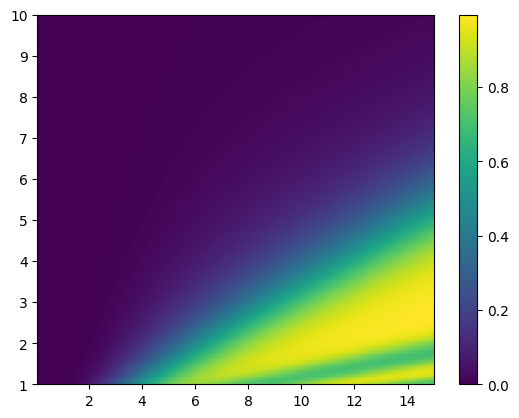

In [200]:
extent = [tau_values[0]*herm_norm, tau_values[-1]*herm_norm, m_values[0], m_values[-1]]

fig, ax = plt.subplots()
im = ax.imshow(data, interpolation='nearest', extent=extent, aspect="auto")
cbar = fig.colorbar(im, ax=ax)